# Adding constraints to Neural Networks 

## Outline

The goal of this notebook is to show how a physical or mathematical constraint can be built in to the learning process to try and nudge the ML model towards more consistent solutions.

## Physical constraints in L96

The **$1^{st}$ order equation L96 model**, 
\begin{equation}
\frac{d}{dt} X_k
= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F 
\end{equation}
conserves energy, 
$$E_X = \frac{1}{2}<X_K^2>,$$ 
in the unforced and undamped form (last 2 terms on the RHS are zero), which results due to the form of the non-linearity. 

However, the **$2^{nd}$ order equation L96 model**
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
\\
\frac{d}{dt} Y_{j,k}
&= - cbY_{j+1,k} \left( Y_{j+2,k} - Y_{j-1,k} \right) - c Y_{j,k} + \frac{hc}{b} X_k
\end{align}
does not have the same conservation property. Instead, for the unforced and undamped system the total energy, 
$$E = E_X + E_Y = \frac{1}{2}(<X_K^2> + <Y_j^2>),$$ 
is conserved, with the "subgrid tendencies" being the exchange terms ($<X_kY_{j,k}>$) between the large scale ($\frac{1}{2}<X_K^2>$) and small scale energy reservoirs $\frac{1}{2}<Y_j^2>$. 

Using energetic arguments to contrain a parameterization is non-trivial, but can prove to be very beneficial. For example the Gent-McWilliams scheme guarantees that the sub-grid parameterization will reduce APE. The GEOMETRIC parameterization keeps track of sub-grid energy and the exchange between the resolved and sub-grid energy, in an attempt to have total energy conservation. 


## L96 model with momentum conserving term
As shown above, the L96 model conserves total energy that is contained over both X and Y variables. However, for demonstration purposes we created a modified L96, where the coupling term is momentum conserving. 
This is a bit silly to do, as the L96 model does not conserve momentum (but no one can stop you!). This also changes the energetics of the original L96. The main reason for this choice was because it was the easiest to implement. 

The equations of the new model are: 
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \left( \frac{hc}{b} \right) \left(\sum_{j=0}^{J-1} Y_{j,k-1} - \sum_{j=0}^{J-1} Y_{j,k+1}\right)
\\
\frac{d}{dt} Y_{j,k}
&= - cbY_{j+1,k} \left( Y_{j+2,k} - Y_{j-1,k} \right) - c Y_{j,k} + \frac{hc}{b} X_k
\end{align}

The small scale forcing from the small scale to the large scale is:
\begin{equation}
G_K = S_{k-1} - S_{k+1} = - \left( \frac{hc}{b} \right) \left(\sum_{j=0}^{J-1} Y_{j,k-1} - \sum_{j=0}^{J-1} Y_{j,k+1}\right)
\end{equation}
 
It is clear that summing $G_k$ over the full domain is identically zero, since it is in a flux form. This term does not input any net momentum into the system, $<G_k>=0$. We will use this as a contrain in this exercise. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torch import nn, optim
from tqdm import tqdm

In [2]:
# Load modules for the model
from L96_conservative_model import L96,  L96_eq1_xdot, integrate_L96_2t # L96_model_XYtend Adds the option to ouptput the subgrid tendencies (effect of Y on X)
from L96_conservative_model import EulerFwd, RK2, RK4 
# Note: We are using a slightly different L96 model here. 

/home/jovyan/L96_demo/notebooks/L96_conservative_model.py:16: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def L96_eq1_xdot(X, F):
/home/jovyan/L96_demo/notebooks/L96_conservative_model.py:37: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def L96_2t_xdot_ydot(X, Y, F, h, b, c):


In [3]:
plt.style.use("seaborn-v0_8")
plt.rcParams["font.size"] = 16

In [5]:
# Simulate the world

time_steps = 20000
Forcing, dt, T = 12, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32
K = 8
J = 32
W = L96(K, J, F=Forcing)

# Get training data for the neural network.
# - Run the true state and output subgrid tendencies (the effect of Y on X is xytrue):
X_true, y, T_true, S_true = W.run(dt, T, store=True)

In [6]:
# G_k = S_(k-1) - S_(k+1)
G_true = np.roll(S_true, 1, axis=1) - np.roll(S_true, -1, axis=1)

In [7]:
# convert to xarray for convenience

X_true_xr = xr.DataArray(
    X_true, dims=["time", "K"], coords={"time": T_true, "K": np.arange(K)}
).rename("X")
Y_xr = xr.DataArray(
    y, dims=["time", "JK"], coords={"time": T_true, "JK": np.arange(K * J)}
).rename("Y")
S_true_xr = xr.DataArray(
    S_true, dims=["time", "K"], coords={"time": T_true, "K": np.arange(K)}
).rename("S")
G_true_xr = xr.DataArray(
    G_true, dims=["time", "K"], coords={"time": T_true, "K": np.arange(K)}
).rename("G")

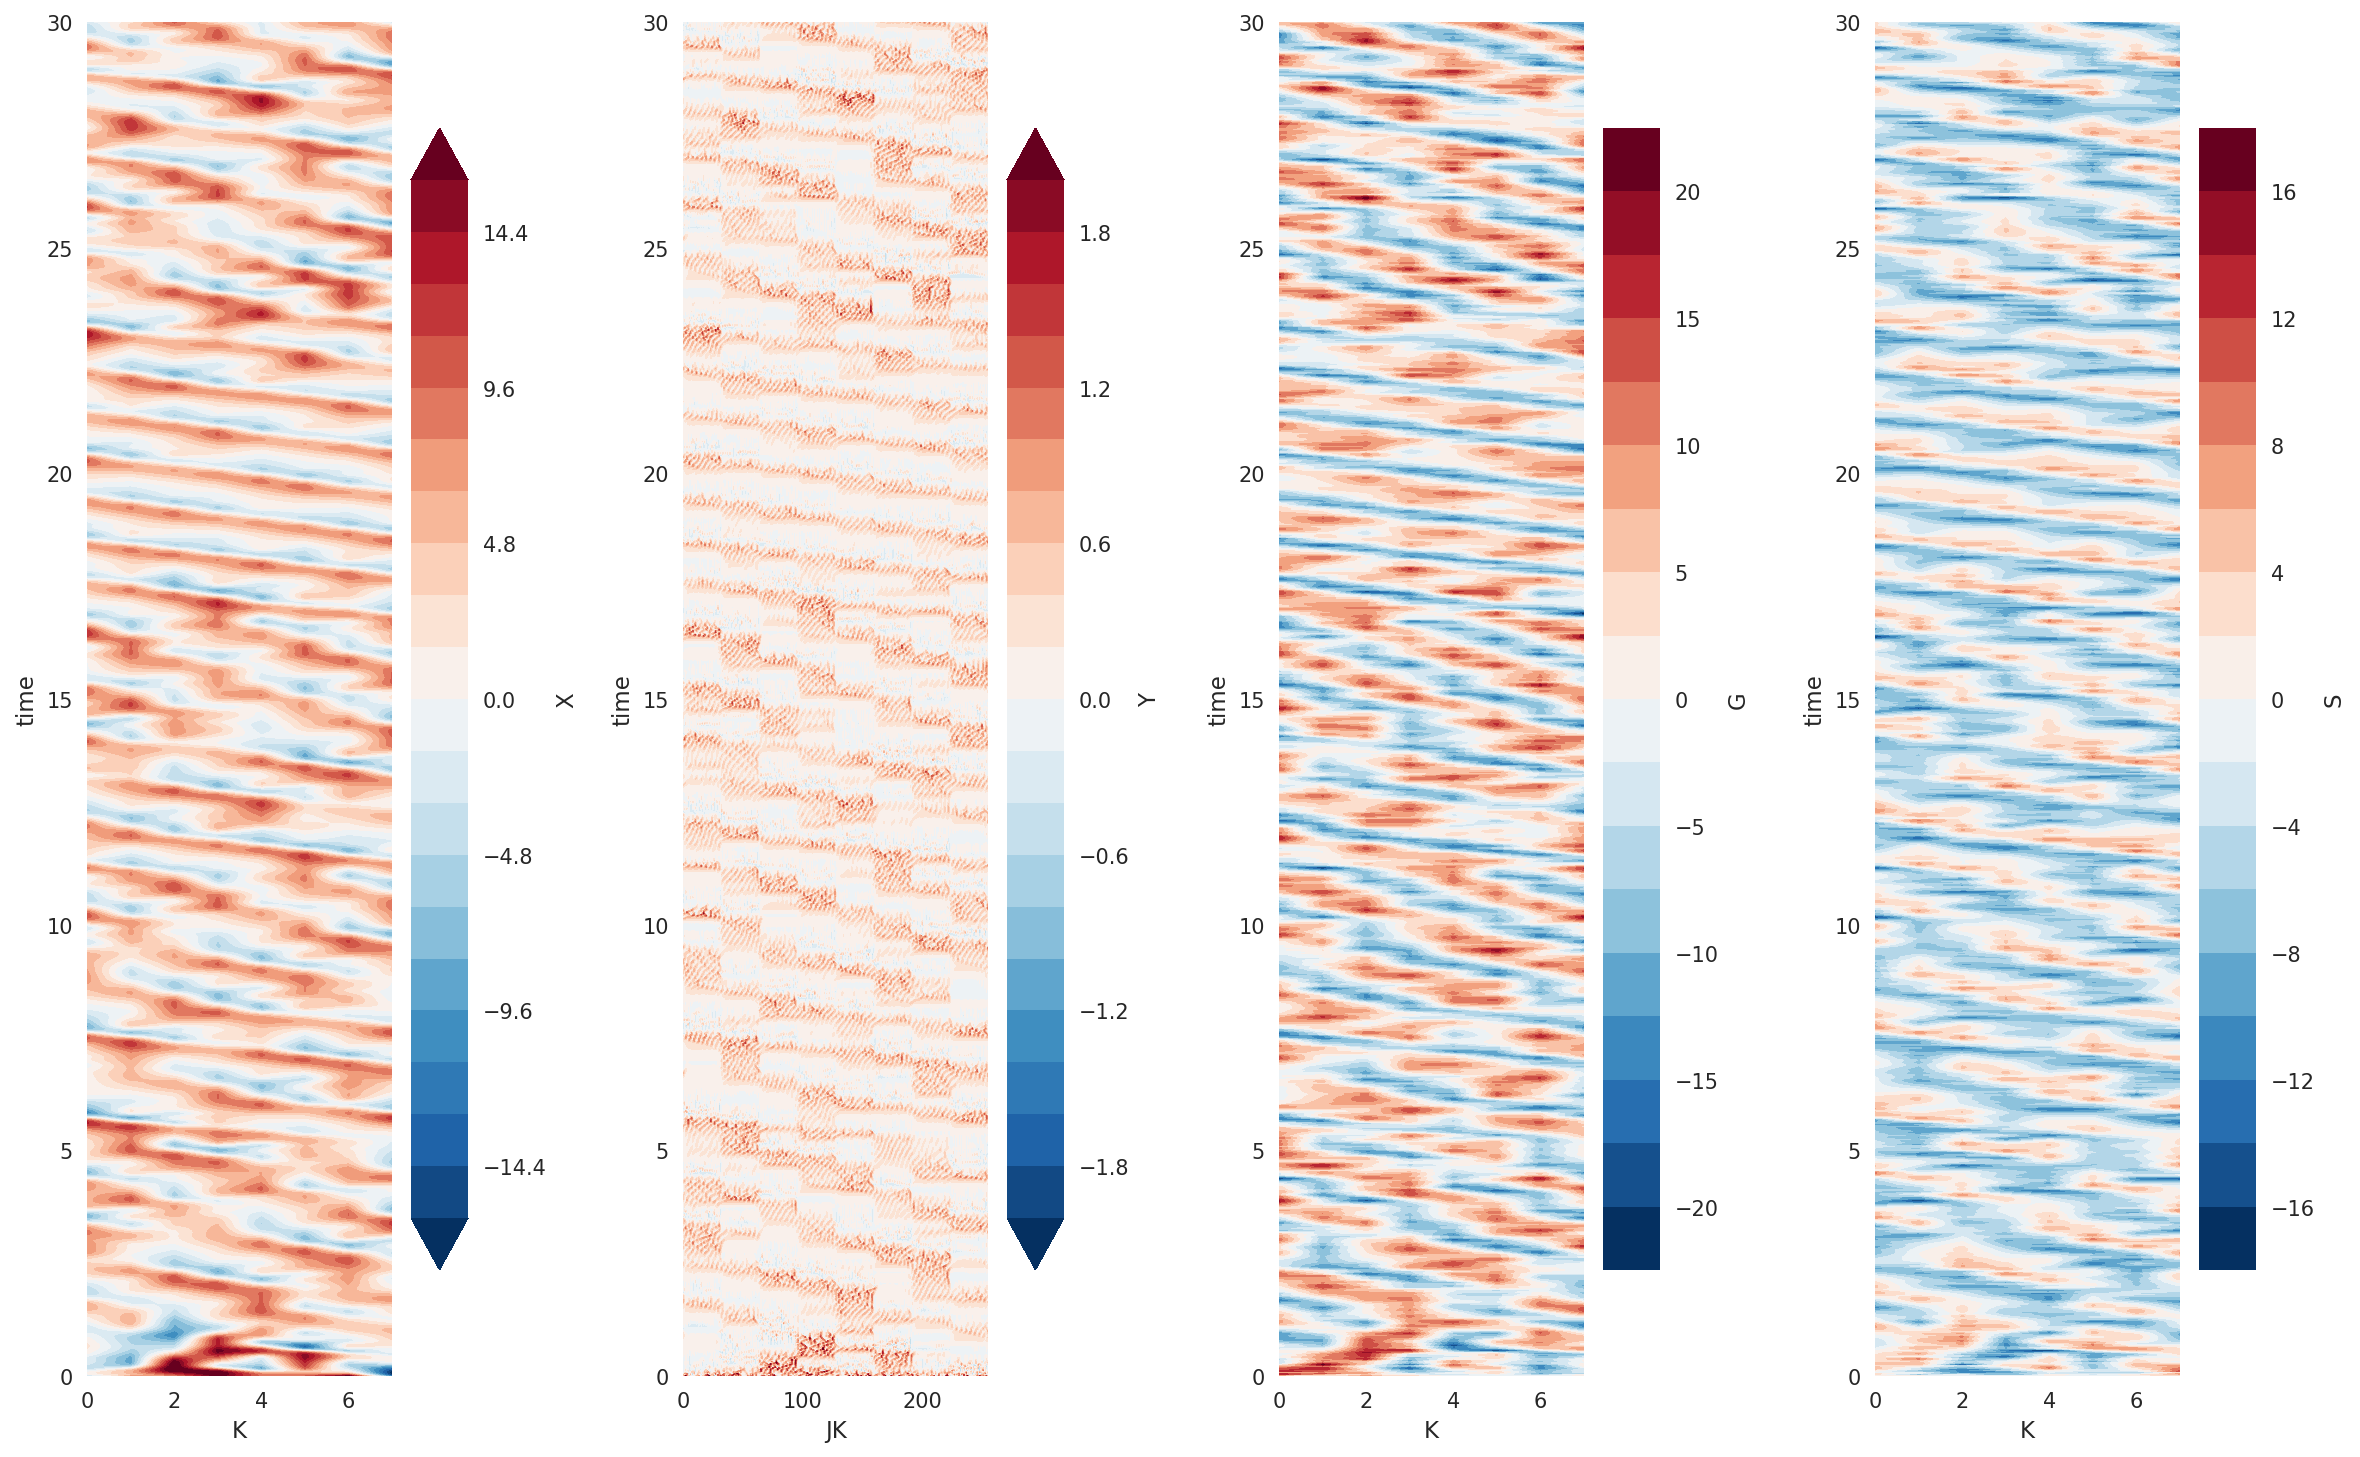

In [8]:
plt.figure(figsize=(16, 10), dpi=150)

plt.subplot(141)
X_true_xr.sel(time=slice(0, 30)).plot.contourf(vmin=-16, levels=21)

plt.subplot(142)
Y_xr.sel(time=slice(0, 30)).plot.contourf(vmin=-2, levels=21)

plt.subplot(143)
G_true_xr.sel(time=slice(0, 30)).plot.contourf(levels=21)

plt.subplot(144)
S_true_xr.sel(time=slice(0, 30)).plot.contourf(levels=21)

plt.tight_layout();

The modified system looks fairly organized and chaotic. So the essence of the original L96 still remains, which is what we wanted.

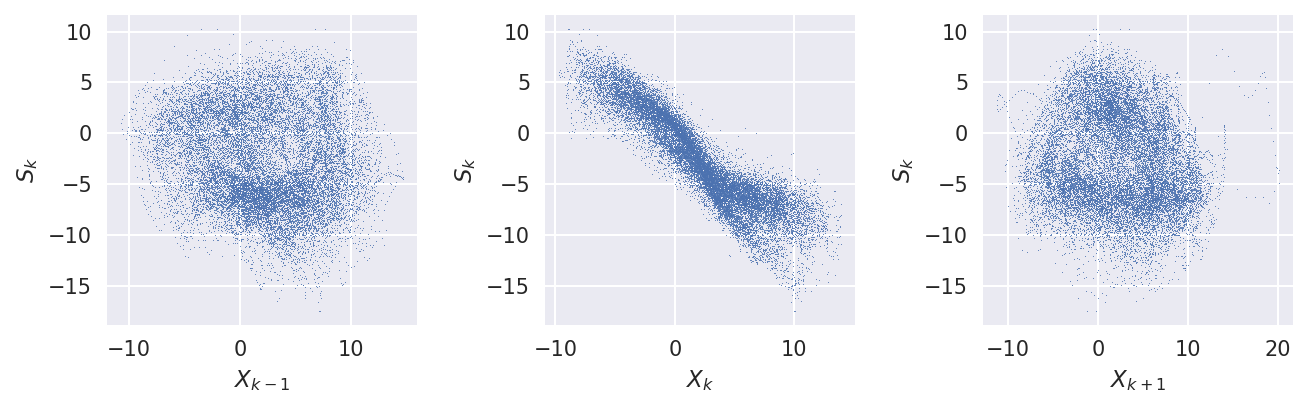

In [9]:
plt.figure(figsize=(9, 3), dpi=150)

plt.subplot(131)
plt.plot(X_true_xr.sel(K=0), S_true_xr.sel(K=1), ".", markersize=1)
plt.xlabel("$X_{k-1}$")
plt.ylabel("$S_{k}$")

plt.subplot(132)
plt.plot(X_true_xr.sel(K=1), S_true_xr.sel(K=1), ".", markersize=1)
plt.xlabel("$X_{k}$")
plt.ylabel("$S_{k}$")

plt.subplot(133)
plt.plot(X_true_xr.sel(K=2), S_true_xr.sel(K=1), ".", markersize=1)
plt.xlabel("$X_{k+1}$")
plt.ylabel("$S_{k}$")

plt.tight_layout();

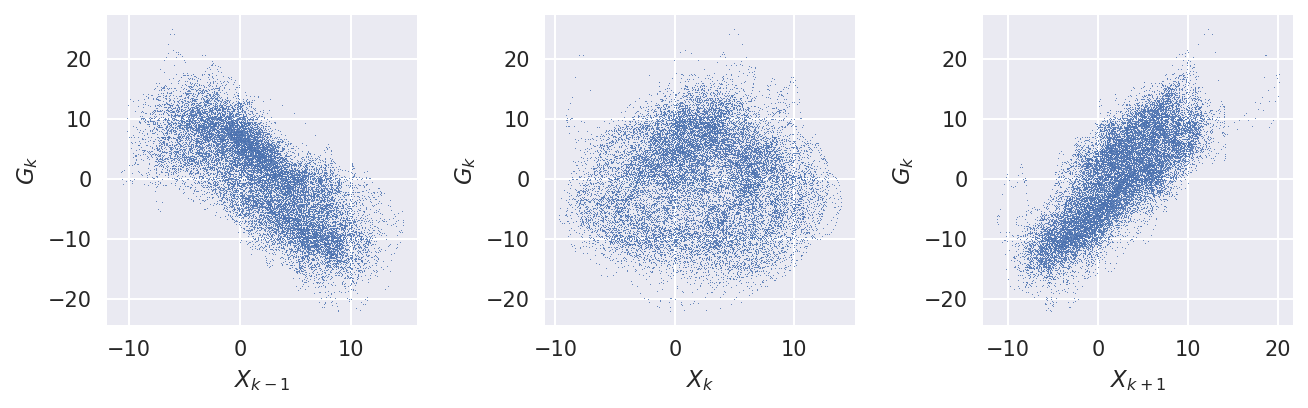

In [10]:
plt.figure(figsize=(9, 3), dpi=150)

plt.subplot(131)
plt.plot(X_true_xr.sel(K=0), G_true_xr.sel(K=1), ".", markersize=1)
plt.xlabel("$X_{k-1}$")
plt.ylabel("$G_{k}$")

plt.subplot(132)
plt.plot(X_true_xr.sel(K=1), G_true_xr.sel(K=1), ".", markersize=1)
plt.xlabel("$X_{k}$")
plt.ylabel("$G_{k}$")

plt.subplot(133)
plt.plot(X_true_xr.sel(K=2), G_true_xr.sel(K=1), ".", markersize=1)
plt.xlabel("$X_{k+1}$")
plt.ylabel("$G_{k}$")

plt.tight_layout();

Since the dependence of Y on X remains the same, G now depends on the neighbouring points (and not the K itself).

/tmp/ipykernel_1155/2290824139.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


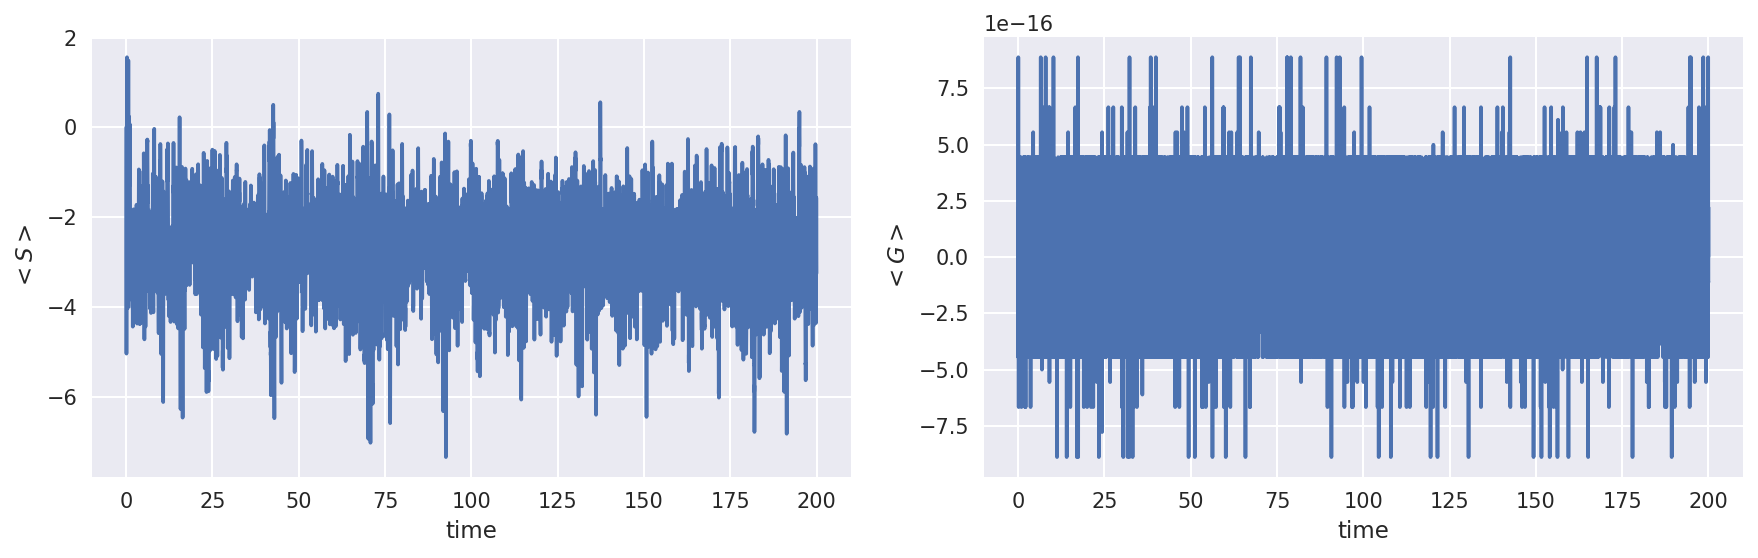

In [11]:
plt.figure(figsize=(12, 4), dpi=150)
plt.subplot(121)
S_true_xr.mean("K").plot()
plt.ylabel("$<S>$")
# plt.title('Averaged subgrid term')
plt.tight_layout()

plt.subplot(122)
G_true_xr.mean("K").plot()
plt.ylabel("$<G>$")
# plt.title('Averaged subgrid term')
plt.tight_layout();

The momentum input from the subgrid term is essentially zero (to numerical precision), as should be. 

**What should we learn using ML?**  
We will do three types of learning (all fully non-local):  
a) Learn $G_k$ directly as a function of $X_k$s by minimizing a MSE loss.  
b) Learn $G_k$ directly as a function of $X_k$s by minimizing a MSE loss + minimizing $<G_k>$.   
c) Learn $S_k$ as a function of $X_k$s, and then $<G_k>$ will be zero by design.  
d) Learn $S_k$ but with $G_k$ being the goal. (This will introduce the Gauge problem).

*We chose MSE as a loss function because as shown earlier, the learning for L96 is not sensitive to the choice of loss function.*

In [12]:
### Split into Training and testing data

val_size = 4000  # number of time steps for validation

# train:
X_true_train = X_true[
    :-val_size, :
]  # Flatten because we first use single input as a sample
subgrid_G_tend_train = G_true[:-val_size, :]
subgrid_S_tend_train = S_true[:-val_size, :]

# test:
X_true_test = X_true[-val_size:, :]
subgrid_G_tend_test = G_true[-val_size:, :]
subgrid_S_tend_test = S_true[-val_size:, :]

# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

### For the cases where will learn G_k

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(X_true_train).double(),
    torch.from_numpy(subgrid_G_tend_train).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(X_true_test).double(),
    torch.from_numpy(subgrid_G_tend_test).double(),
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

# For the cases where will learn S_k

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(X_true_train).double(),
    torch.from_numpy(subgrid_S_tend_train).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader_S = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(X_true_test).double(),
    torch.from_numpy(subgrid_S_tend_test).double(),
)

loader_S_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

In [13]:
# Class for the neural network architecture
class Net_ANN(nn.Module):
    def __init__(self, name="Default"):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
        self.name = name

    #         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting.

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [14]:
# Setup function to take one step in the learning
def train_model(net, criterion, trainloader, optimizer):
    # set model in to training mode
    net.train()

    # Loop through all the training subsets (notice we batched in size of 1024)
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs

        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)

        loss = criterion(prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights

In [15]:
# Setup function that evaluates a number of metrics at each training step
def test_model(
    net, criterion, metric_fun, trainloader, optimizer, text="validation", print_flag=0
):
    net.eval()  # Evaluation mode (important when having dropout layers)

    test_loss = 0
    test_metric = 0
    test_metric_2 = 0

    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)  # Calculating loss
            metric = metric_fun(prediction, b_y)

            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
            test_metric = test_metric + metric.data.numpy()  # Keep track of the loss
            test_metric_2 = (
                test_metric_2
                + torch.mean(torch.abs(torch.mean(prediction, axis=1))).data.numpy()
            )

        test_loss /= len(trainloader)  # dividing by the number of batches
        test_metric /= len(trainloader)  # dividing by the number of batches
        test_metric_2 /= len(trainloader)
    #         print(len(trainloader))
    # print(test_loss)

    if print_flag == 1:
        print(
            f"{net.name} {text} loss: {test_loss}, metric_1: {test_metric}, metric_2: {test_metric_2}"
        )

    return test_loss, test_metric, test_metric_2

In [16]:
# The ML models

lr = 0.001  # the learning rate

# (a) Learn G_k using MSE
criterion_a = torch.nn.MSELoss()
nn_a = Net_ANN("Learn Gk").double()
optimizer_a = optim.Adam(nn_a.parameters(), lr=lr)

# (b) learn G_k using MSE + condition of reducing momentum forcing

alpha = 100  # This is the regularization parameter

In [17]:
def custom_loss(Ypred, Ytrue):
    # loss = MSE + net momentum forcing penalty
    loss = torch.mean((Ypred - Ytrue) ** 2) + alpha * torch.mean(
        torch.abs(torch.mean(Ypred, axis=1))
    )
    return loss

In [18]:
criterion_b = custom_loss
nn_b = Net_ANN("Learn Gk w/ constrain").double()
optimizer_b = optim.Adam(nn_b.parameters(), lr=lr)

# (c) Learn S_k using MSE
criterion_c = torch.nn.MSELoss()
nn_c = Net_ANN("Learn Sk").double()
optimizer_c = optim.Adam(nn_c.parameters(), lr=lr)

In [19]:
# (d) Learn S_k but with G_k as the objective
def custom_loss2(Spred, Gtrue):
    # Gtrue = np.roll(Strue, 1, axis=1) - np.roll(Strue, -1, axis=1)
    Gpred = torch.roll(Spred, 1, dims=1) - torch.roll(Spred, -1, dims=1)
    loss = torch.mean((Gpred - Gtrue) ** 2)
    return loss

In [20]:
criterion_d = custom_loss2
nn_d = Net_ANN("Learn Sk from Gk").double()
optimizer_d = optim.Adam(nn_d.parameters(), lr=lr)

The custom loss function: 
$$
loss = (G_{pred} - G_{true})^2 + \alpha |<G_k>|
$$

In model (b) we have to pick a value for the degree of regularization $\alpha$. Here we use a constant value, but this value itself needed to be determined. We determined it using some rough testing with the L-curve criterion (read about it more [here](https://www.sintef.no/globalassets/project/evitameeting/2005/lcurve.pdf)). 

In [21]:
# Do the training

n_epochs = 100

# Containers
validation_stat_a = {
    "loss": np.zeros((n_epochs)),
    "metric": np.zeros((n_epochs)),
    "metric2": np.zeros((n_epochs)),
}
train_stat_a = {
    "loss": np.zeros((n_epochs)),
    "metric": np.zeros((n_epochs)),
    "metric2": np.zeros((n_epochs)),
}

validation_stat_b = {
    "loss": np.zeros((n_epochs)),
    "metric": np.zeros((n_epochs)),
    "metric2": np.zeros((n_epochs)),
}
train_stat_b = {
    "loss": np.zeros((n_epochs)),
    "metric": np.zeros((n_epochs)),
    "metric2": np.zeros((n_epochs)),
}

validation_stat_c = {
    "loss": np.zeros((n_epochs)),
    "metric": np.zeros((n_epochs)),
    "metric2": np.zeros((n_epochs)),
}
train_stat_c = {
    "loss": np.zeros((n_epochs)),
    "metric": np.zeros((n_epochs)),
    "metric2": np.zeros((n_epochs)),
}

validation_stat_d = {
    "loss": np.zeros((n_epochs)),
    "metric": np.zeros((n_epochs)),
    "metric2": np.zeros((n_epochs)),
}
train_stat_d = {
    "loss": np.zeros((n_epochs)),
    "metric": np.zeros((n_epochs)),
    "metric2": np.zeros((n_epochs)),
}

In [22]:
def helper_fun(nn_sel, criterion, metric, loader, loader_test, optimizer):
    train_model(nn_sel, criterion, loader, optimizer)

    return test_model(
        nn_sel, criterion, metric, loader, optimizer, text="train"
    ), test_model(nn_sel, criterion, metric, loader_test, optimizer, print_flag=0)

In [ ]:
for epoch in tqdm(range(n_epochs)):
    # print("--------------")
    # print("Epoch num : " + str(epoch))

    # (a)
    (
        validation_stat_a["loss"][epoch],
        validation_stat_a["metric"][epoch],
        validation_stat_a["metric2"][epoch],
    ), (
        train_stat_a["loss"][epoch],
        train_stat_a["metric"][epoch],
        train_stat_a["metric2"][epoch],
    ) = helper_fun(
        nn_a, criterion_a, criterion_a, loader, loader_test, optimizer_a
    )

    # (b)
    (
        validation_stat_b["loss"][epoch],
        validation_stat_b["metric"][epoch],
        validation_stat_b["metric2"][epoch],
    ), (
        train_stat_b["loss"][epoch],
        train_stat_b["metric"][epoch],
        train_stat_b["metric2"][epoch],
    ) = helper_fun(
        nn_b, criterion_b, criterion_a, loader, loader_test, optimizer_b
    )

    # (c)
    (
        validation_stat_c["loss"][epoch],
        validation_stat_c["metric"][epoch],
        validation_stat_c["metric2"][epoch],
    ), (
        train_stat_c["loss"][epoch],
        train_stat_c["metric"][epoch],
        train_stat_c["metric2"][epoch],
    ) = helper_fun(
        nn_c, criterion_c, criterion_a, loader_S, loader_S_test, optimizer_c
    )

    # (d)
    # notice that this learns Sk (what is predicted), but the MSE is relative to Gk.
    (
        validation_stat_d["loss"][epoch],
        validation_stat_d["metric"][epoch],
        validation_stat_d["metric2"][epoch],
    ), (
        train_stat_d["loss"][epoch],
        train_stat_d["metric"][epoch],
        train_stat_d["metric2"][epoch],
    ) = helper_fun(
        nn_d, criterion_d, criterion_d, loader, loader_test, optimizer_d
    )

 81%|████████  | 81/100 [12:24<02:58,  9.41s/it]

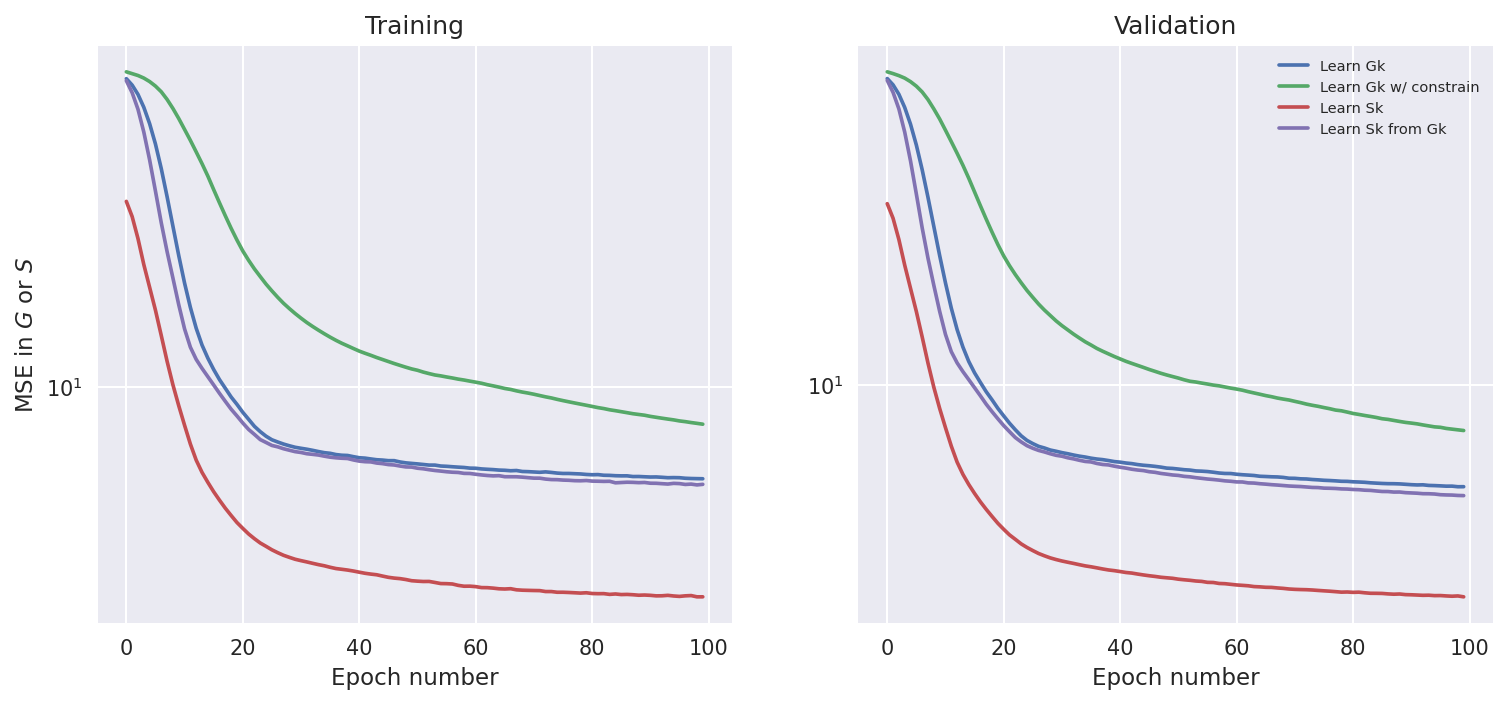

In [24]:
fig = plt.figure(figsize=(12, 5), dpi=150)

ax = plt.subplot(121)
ax.plot(range(n_epochs), train_stat_a["metric"], label=nn_a.name)
ax.plot(range(n_epochs), train_stat_b["metric"], label=nn_b.name)
ax.plot(range(n_epochs), train_stat_c["metric"], label=nn_c.name)
ax.plot(range(n_epochs), train_stat_d["metric"], label=nn_d.name)

plt.yscale("log")
# ax.set_xlim([0, 20])
ax.set_ylabel("MSE in $G$ or $S$")
ax.set_xlabel("Epoch number")
ax.set_title("Training")


ax = plt.subplot(122)
ax.plot(range(n_epochs), validation_stat_a["metric"], label=nn_a.name)
ax.plot(range(n_epochs), validation_stat_b["metric"], label=nn_b.name)
ax.plot(range(n_epochs), validation_stat_c["metric"], label=nn_c.name)
ax.plot(range(n_epochs), validation_stat_d["metric"], label=nn_d.name)
plt.yscale("log")
ax.legend(fontsize=7)
ax.set_xlabel("Epoch number")
# ax.set_xlim([0, 20])
ax.set_title("Validation");

Looking at the plots above we see that the training went well for all the cases, as the loss function is reduced. Note tht we should not compare the MSE of the cases where G_k is learnt with the cases where S_k is learnt, since the learning objective was different. 

We also see that adding a constrain to minimize net momentum input when learning G_k, made the MSE for the model a bit higher, as it is trying to reduce two things at once. 

It is interesting to note that even the model without the constraint is trying to reduce the momentum input over training epochs, which shows that it is something that the learning is trying to learn without help. (there might be situations with limited data where this help is important, but not super helpful for L96).

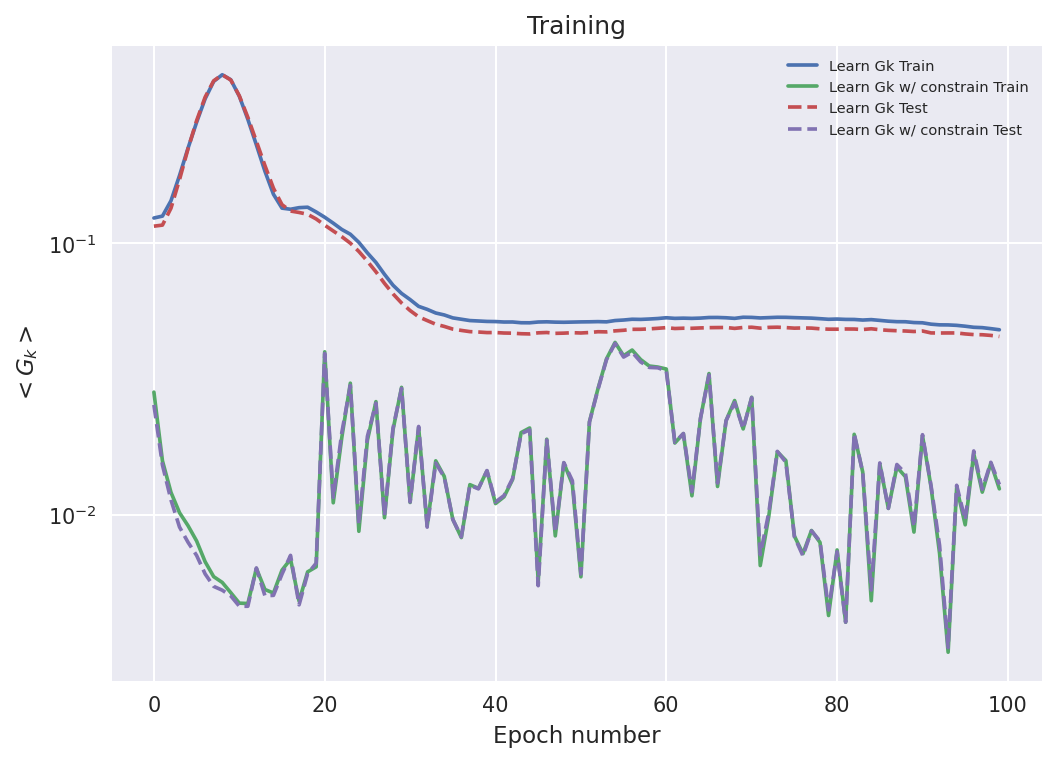

In [26]:
# How do the models that directly learn Gk do at mom cons of that term.
fig = plt.figure(dpi=150)

ax = plt.subplot(111)
ax.plot(range(n_epochs), train_stat_a["metric2"], label=nn_a.name + " Train")
ax.plot(range(n_epochs), train_stat_b["metric2"], label=nn_b.name + " Train")

ax.plot(range(n_epochs), validation_stat_a["metric2"], "--", label=nn_a.name + " Test")
ax.plot(range(n_epochs), validation_stat_b["metric2"], "--", label=nn_b.name + " Test")
ax.legend(fontsize=7)
plt.yscale("log")
# ax.set_xlim([0, 20])
ax.set_ylabel("$<G_k>$")
ax.set_xlabel("Epoch number")
ax.set_title("Training");

In [27]:
# Look at predictions
nn_a.eval()
nn_b.eval()
nn_c.eval()
nn_d.eval()

pred_G_a = nn_a(torch.from_numpy(X_true_test)).detach().numpy()
pred_G_b = nn_b(torch.from_numpy(X_true_test)).detach().numpy()
pred_S_c = nn_c(torch.from_numpy(X_true_test)).detach().numpy()
pred_G_c = np.roll(pred_S_c, 1, axis=1) - np.roll(
    pred_S_c, -1, axis=1
)  # Since the last model predicts the S, we need to calculate G.
pred_S_d = nn_d(torch.from_numpy(X_true_test)).detach().numpy()
pred_G_d = np.roll(pred_S_d, 1, axis=1) - np.roll(
    pred_S_d, -1, axis=1
)  # Since the last model predicts the S, we need to calculate G.

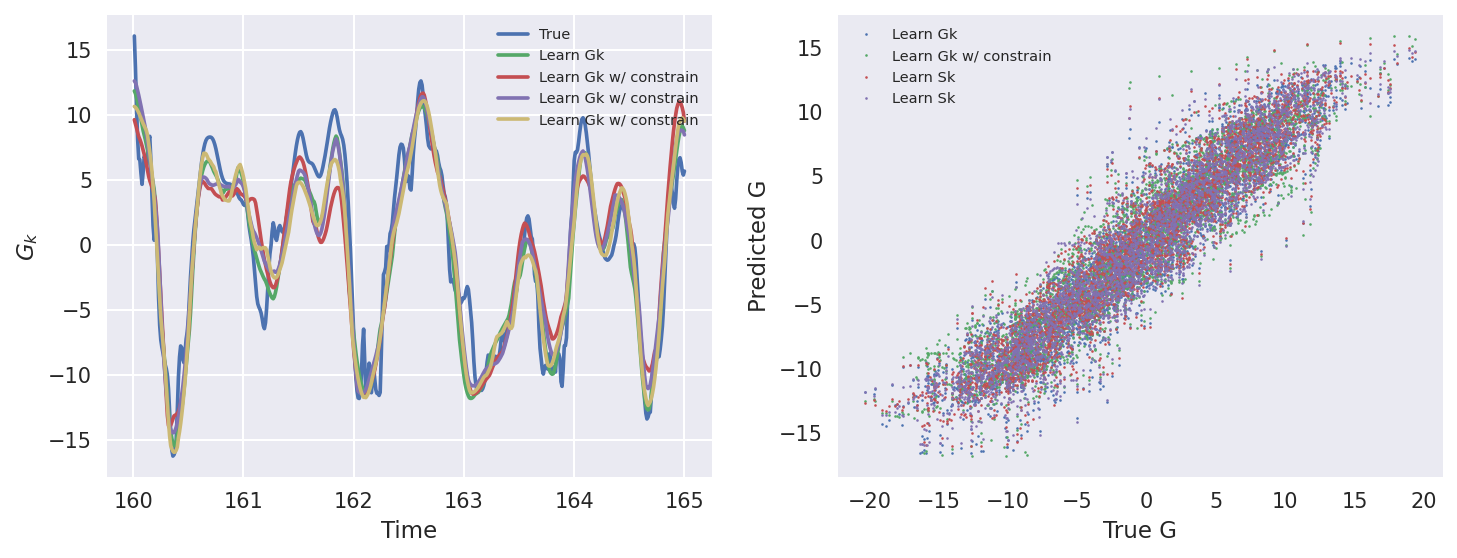

In [28]:
n = 500
k = 2

T_test = T_true[-val_size:]

plt.figure(figsize=(10, 4), dpi=150)

plt.subplot(121)
plt.plot(T_test[:n], subgrid_G_tend_test[:n, k], label="True")
plt.plot(T_test[:n], pred_G_a[:n, k], label=nn_a.name)
plt.plot(T_test[:n], pred_G_b[:n, k], label=nn_b.name)
plt.plot(T_test[:n], pred_G_c[:n, k], label=nn_b.name)
plt.plot(T_test[:n], pred_G_d[:n, k], label=nn_b.name)
plt.xlabel("Time")
plt.ylabel("$G_k$")

plt.legend(fontsize=7)

plt.subplot(122)
# plt.plot(Xtrue_test[:,k],  subgrid_tend_test[:,k], '.', markersize=1)
plt.plot(
    subgrid_G_tend_test[:, k], pred_G_a[:, k], ".", markersize=2.5, label=nn_a.name
)
plt.plot(
    subgrid_G_tend_test[:, k], pred_G_b[:, k], ".", markersize=2.5, label=nn_b.name
)
plt.plot(
    subgrid_G_tend_test[:, k], pred_G_c[:, k], ".", markersize=2.5, label=nn_c.name
)
plt.plot(
    subgrid_G_tend_test[:, k], pred_G_d[:, k], ".", markersize=2.5, label=nn_c.name
)

plt.xlabel("True G")
plt.ylabel("Predicted G")
plt.legend(fontsize=7)
# plt.plot(Xtrue_test[:,k],  pred_2.detach().numpy()[:,k], '.', markersize=1.5)
# plt.plot(Xtrue_test[:,k],  pred_3.detach().numpy()[:,k], '.', markersize=1.5)
plt.grid()

plt.tight_layout()

In [29]:
MSE_a = np.mean((subgrid_G_tend_test - pred_G_a) ** 2)
MSE_b = np.mean((subgrid_G_tend_test - pred_G_b) ** 2)
MSE_c = np.mean((subgrid_G_tend_test - pred_G_c) ** 2)
MSE_d = np.mean((subgrid_G_tend_test - pred_G_d) ** 2)

MSE_S_c = np.mean((subgrid_S_tend_test - pred_S_c) ** 2)
MSE_S_d = np.mean((subgrid_S_tend_test - pred_S_d) ** 2)

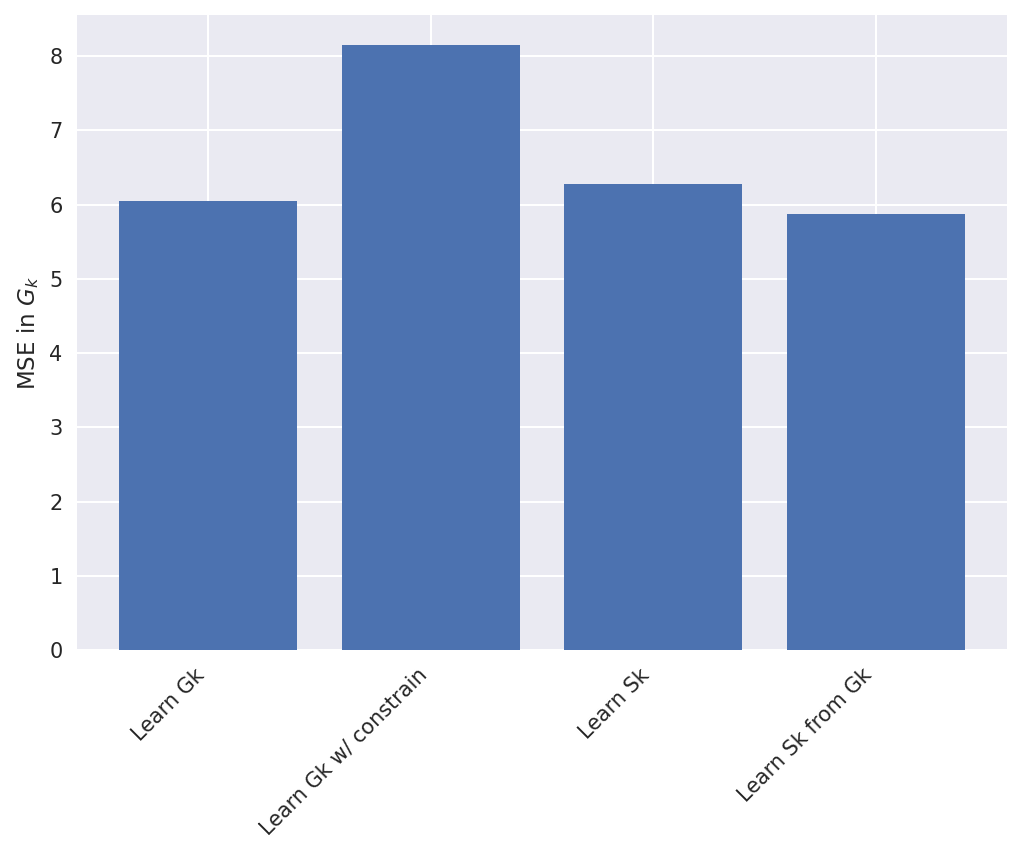

In [30]:
nn_names = [nn_a.name, nn_b.name, nn_c.name, nn_d.name]
MSEs = [MSE_a, MSE_b, MSE_c, MSE_d]

plt.figure(dpi=150)
plt.bar(nn_names, MSEs)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment="right")
plt.ylabel("MSE in $G_k$");
# plt.xlabel('Model')

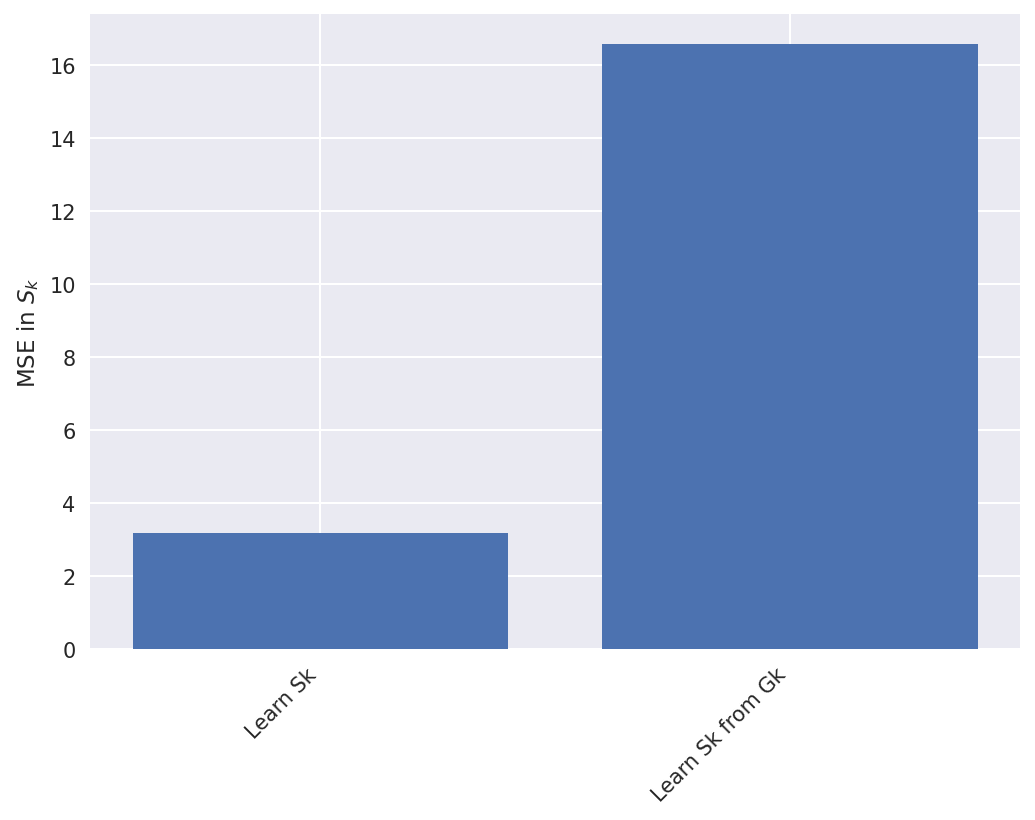

In [31]:
nn_names = [nn_c.name, nn_d.name]
MSEs = [MSE_S_c, MSE_S_d]

plt.figure(dpi=150)
plt.bar(nn_names, MSEs)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment="right")
plt.ylabel("MSE in $S_k$");
# plt.xlabel('Model')

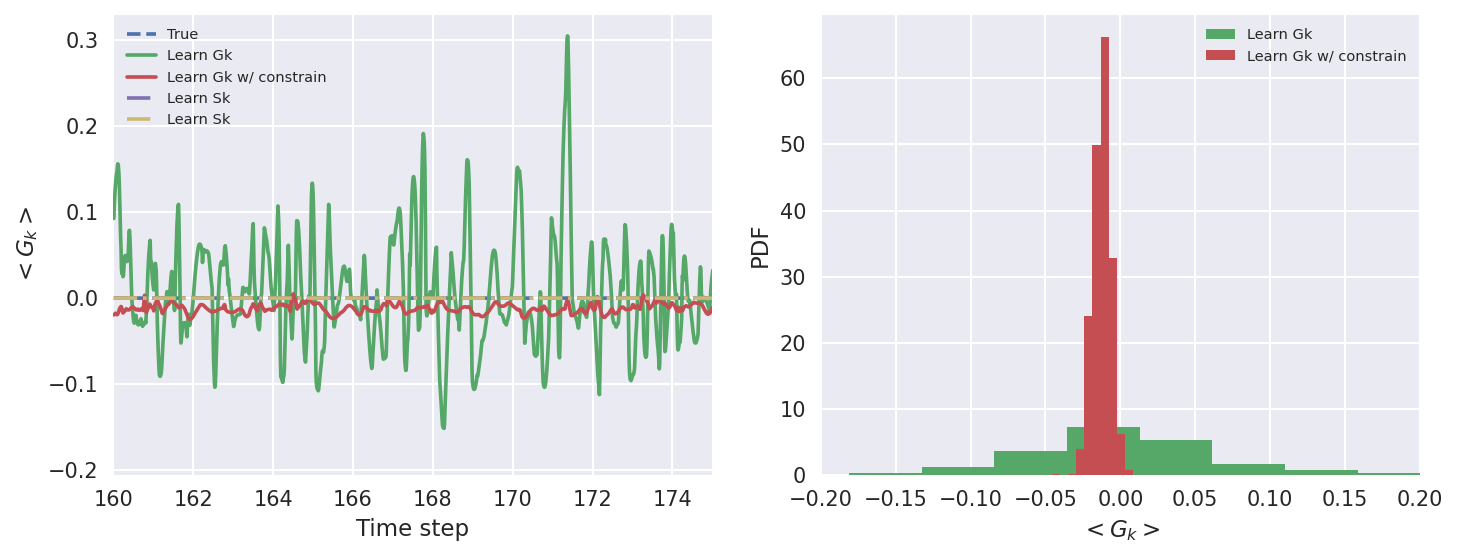

In [32]:
plt.figure(figsize=(10, 4), dpi=150)

plt.subplot(121)
plt.plot(T_test, np.mean(subgrid_G_tend_test, axis=1), "--", label="True")
plt.plot(T_test, np.mean(pred_G_a, axis=1), label=nn_a.name)
plt.plot(T_test, np.mean(pred_G_b, axis=1), label=nn_b.name)
plt.plot(T_test, np.mean(pred_G_c, axis=1), "-.", label=nn_c.name)
plt.plot(T_test, np.mean(pred_G_d, axis=1), "-.", label=nn_c.name)
plt.xlim([160, 175])
plt.legend(fontsize=7)
plt.ylabel("$<G_k>$")
plt.xlabel("Time step")

plt.subplot(122)
plt.hist(0)
plt.hist(np.mean(pred_G_a, axis=1), density=True, label=nn_a.name)
plt.hist(np.mean(pred_G_b, axis=1), density=True, label=nn_b.name)

plt.legend(fontsize=7)

plt.xlabel("$<G_k>$")
plt.ylabel("PDF")
plt.xlim([-0.2, 0.2])

plt.tight_layout()

- The models do quite a good job (visually) at capturing the patterns in the subgrid forcing. 
- The model with the constrain of momentum conservation does a better job of it (pdf width is much smaller), BUT some bias is introduced (median is shifted from 0). 
- From our experimenting this bias is not always the same, and can vary if trainined multiple times. 

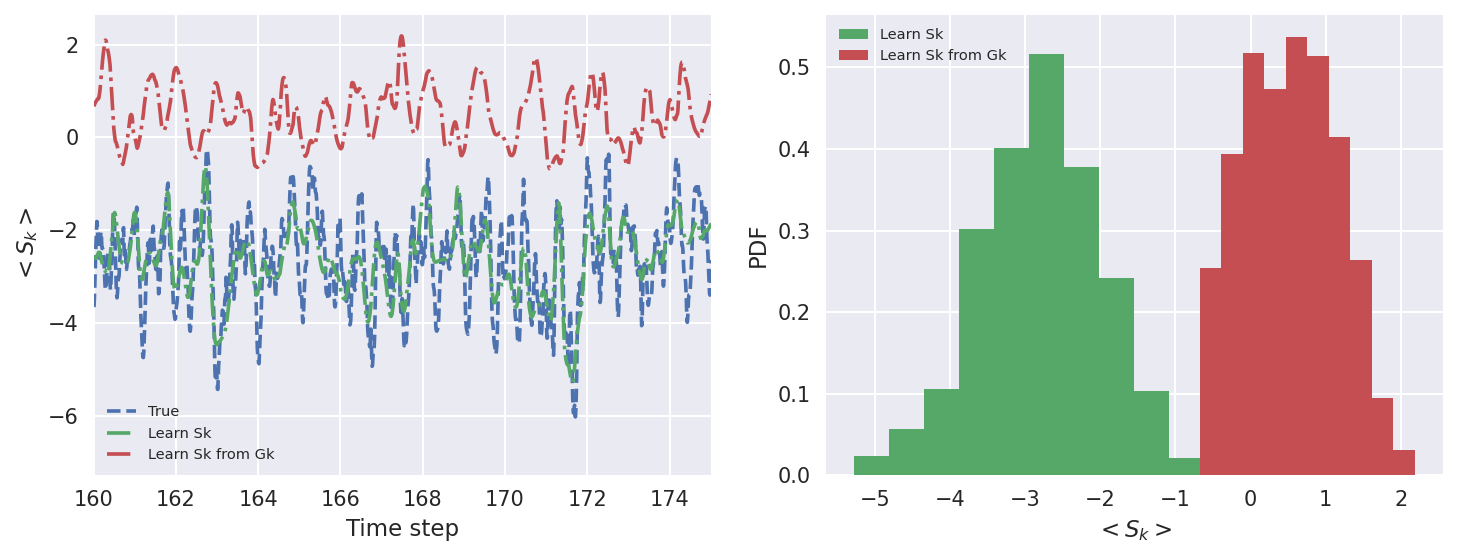

In [33]:
plt.figure(figsize=(10, 4), dpi=150)

plt.subplot(121)
plt.plot(T_test, np.mean(subgrid_S_tend_test, axis=1), "--", label="True")
plt.plot(T_test, np.mean(pred_S_c, axis=1), "-.", label=nn_c.name)
plt.plot(T_test, np.mean(pred_S_d, axis=1), "-.", label=nn_d.name)
plt.xlim([160, 175])
plt.legend(fontsize=7)
plt.ylabel("$<S_k>$")
plt.xlabel("Time step")

plt.subplot(122)
plt.plot(0, 0)
plt.hist(np.mean(pred_S_c, axis=1), density=True, label=nn_c.name)
plt.hist(np.mean(pred_S_d, axis=1), density=True, label=nn_d.name)

plt.legend(fontsize=7)

plt.xlabel("$<S_k>$")
plt.ylabel("PDF")

plt.tight_layout()

**When the model learns Sk from Gk, without knowing anything about Gk. It produces the right Gk, but a Sk that looks very different from the real Sk.**

### Skill of different ML models in prediction

In [34]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency

time_method = RK4

# - a GCM class without any parameterization


class GCM_no_param:
    def __init__(self, F, time_stepping=time_method):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [35]:
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0)).double()

        return L96_eq1_xdot(X, self.F) + np.squeeze(
            self.network(X_torch).data.numpy()
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, histX, histB, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        histX[0] = X
        histB[0] = 0.0

        for n in range(nt):
            # this next if statement is being called twice
            if self.network.linear1.in_features == 1:
                X_torch = torch.from_numpy(X).double()
                X_torch = torch.unsqueeze(X_torch, 1)
            else:
                X_torch = torch.from_numpy(np.expand_dims(X, 0)).double()

            histB[n + 1] = np.squeeze(self.network(X_torch).data.numpy())

            X = self.time_stepping(self.rhs, dt, X, param)
            histX[n + 1], time[n + 1] = X, dt * (n + 1)
        return histX, time, histB

In [36]:
class GCM_network_S:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0)).double()

            predS = self.network(X_torch).data.numpy()
            predG = np.roll(predS, 1, axis=1) - np.roll(predS, -1, axis=1)
        # return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy()) # Adding NN parameterization
        return L96_eq1_xdot(X, self.F) + np.squeeze(predG)  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, histX, histB, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        histX[0] = X
        histB[0] = 0.0

        for n in range(nt):
            # this next if statement is being called twice
            if self.network.linear1.in_features == 1:
                X_torch = torch.from_numpy(X).double()
                X_torch = torch.unsqueeze(X_torch, 1)
            else:
                X_torch = torch.from_numpy(np.expand_dims(X, 0)).double()

            predS = self.network(X_torch).data.numpy()
            predG = np.roll(predS, 1, axis=1) - np.roll(predS, -1, axis=1)
            histB[n + 1] = predG  # np.squeeze(self.network(X_torch).data.numpy())

            X = self.time_stepping(self.rhs, dt, X, param)
            histX[n + 1], time[n + 1] = X, dt * (n + 1)
        return histX, time, histB

In [38]:
T_test = 20

X_full, _, t, S_full = W.run(dt, T_test)  # Full model
G_full = np.roll(S_full, 1, axis=1) - np.roll(S_full, -1, axis=1)
init_cond = X_true[-1, :]

gcm_a = GCM_network(Forcing, nn_a)
X_a, t, G_a = gcm_a(init_cond, dt, int(T_test / dt))

gcm_b = GCM_network(Forcing, nn_b)
X_b, t, G_b = gcm_b(init_cond, dt, int(T_test / dt))

gcm_c = GCM_network_S(Forcing, nn_c)
X_c, t, G_c = gcm_c(init_cond, dt, int(T_test / dt))

gcm_d = GCM_network_S(Forcing, nn_d)
X_d, t, G_d = gcm_d(init_cond, dt, int(T_test / dt))


gcm_no_param = GCM_no_param(Forcing)
X_no_param, t = gcm_no_param(init_cond, dt, int(T_test / dt))

In [39]:
# convert to xarray for convenience
X_full_xr = xr.DataArray(
    X_full, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("X_true")
G_full_xr = xr.DataArray(
    G_full, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("G_true")

X_a_xr = xr.DataArray(
    X_a, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("X_a")
G_a_xr = xr.DataArray(
    G_a, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("G_a")

X_b_xr = xr.DataArray(
    X_b, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("X_b")
G_b_xr = xr.DataArray(
    G_b, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("G_b")

X_c_xr = xr.DataArray(
    X_c, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("X_c")
G_c_xr = xr.DataArray(
    G_c, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("G_c")

X_d_xr = xr.DataArray(
    X_d, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("X_d")
G_d_xr = xr.DataArray(
    G_d, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("G_d")

X_noparam_xr = xr.DataArray(
    X_no_param, dims=["time", "K"], coords={"time": t, "K": np.arange(K)}
).rename("X_noparam")

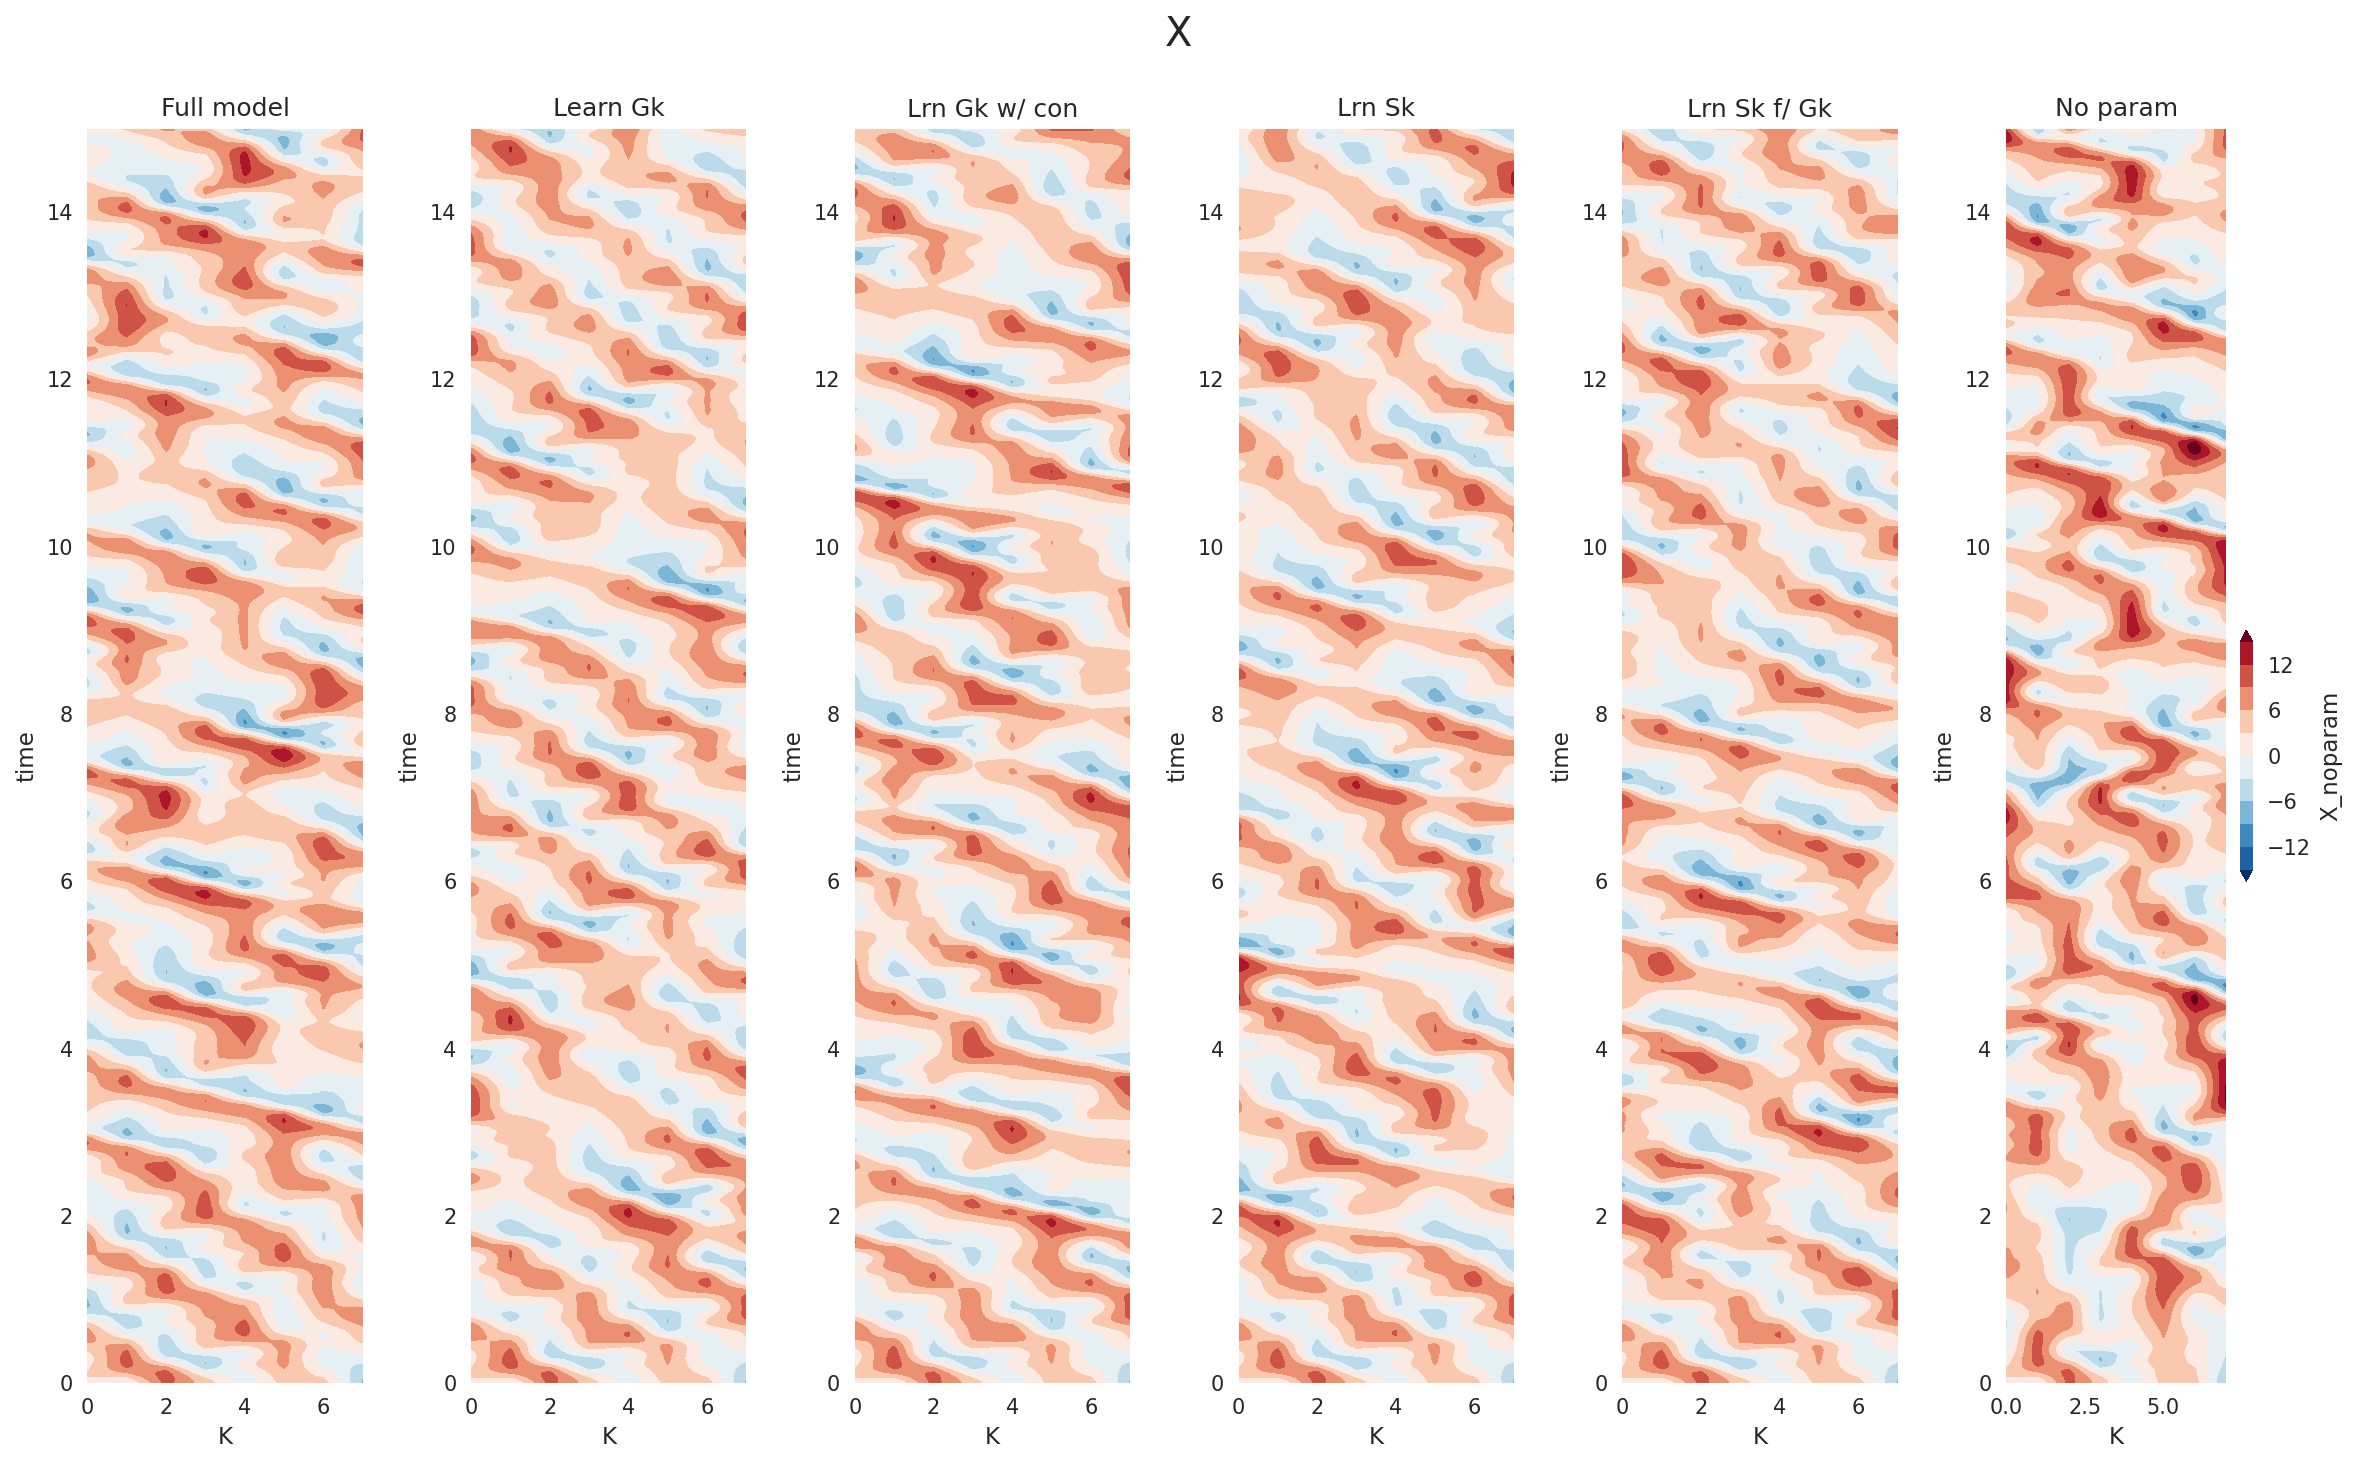

In [40]:
plt.figure(figsize=(16, 10), dpi=150)

plt.subplot(161)
X_full_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-15, 15, 11), extend="both", add_colorbar=False
)
plt.title("Full model")

plt.subplot(162)
X_a_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-15, 15, 11), extend="both", add_colorbar=False
)
plt.title("Learn Gk")

plt.subplot(163)
X_b_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-15, 15, 11), extend="both", add_colorbar=False
)
plt.title("Lrn Gk w/ con")

plt.subplot(164)
X_c_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-15, 15, 11), extend="both", add_colorbar=False
)
plt.title("Lrn Sk")

plt.subplot(165)
X_d_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-15, 15, 11), extend="both", add_colorbar=False
)
plt.title("Lrn Sk f/ Gk")

plt.subplot(166)
X_noparam_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-15, 15, 11),
    extend="both",
    cbar_kwargs={"aspect": 20, "shrink": 0.2},
)
plt.title("No param")

plt.suptitle("X")
plt.tight_layout()

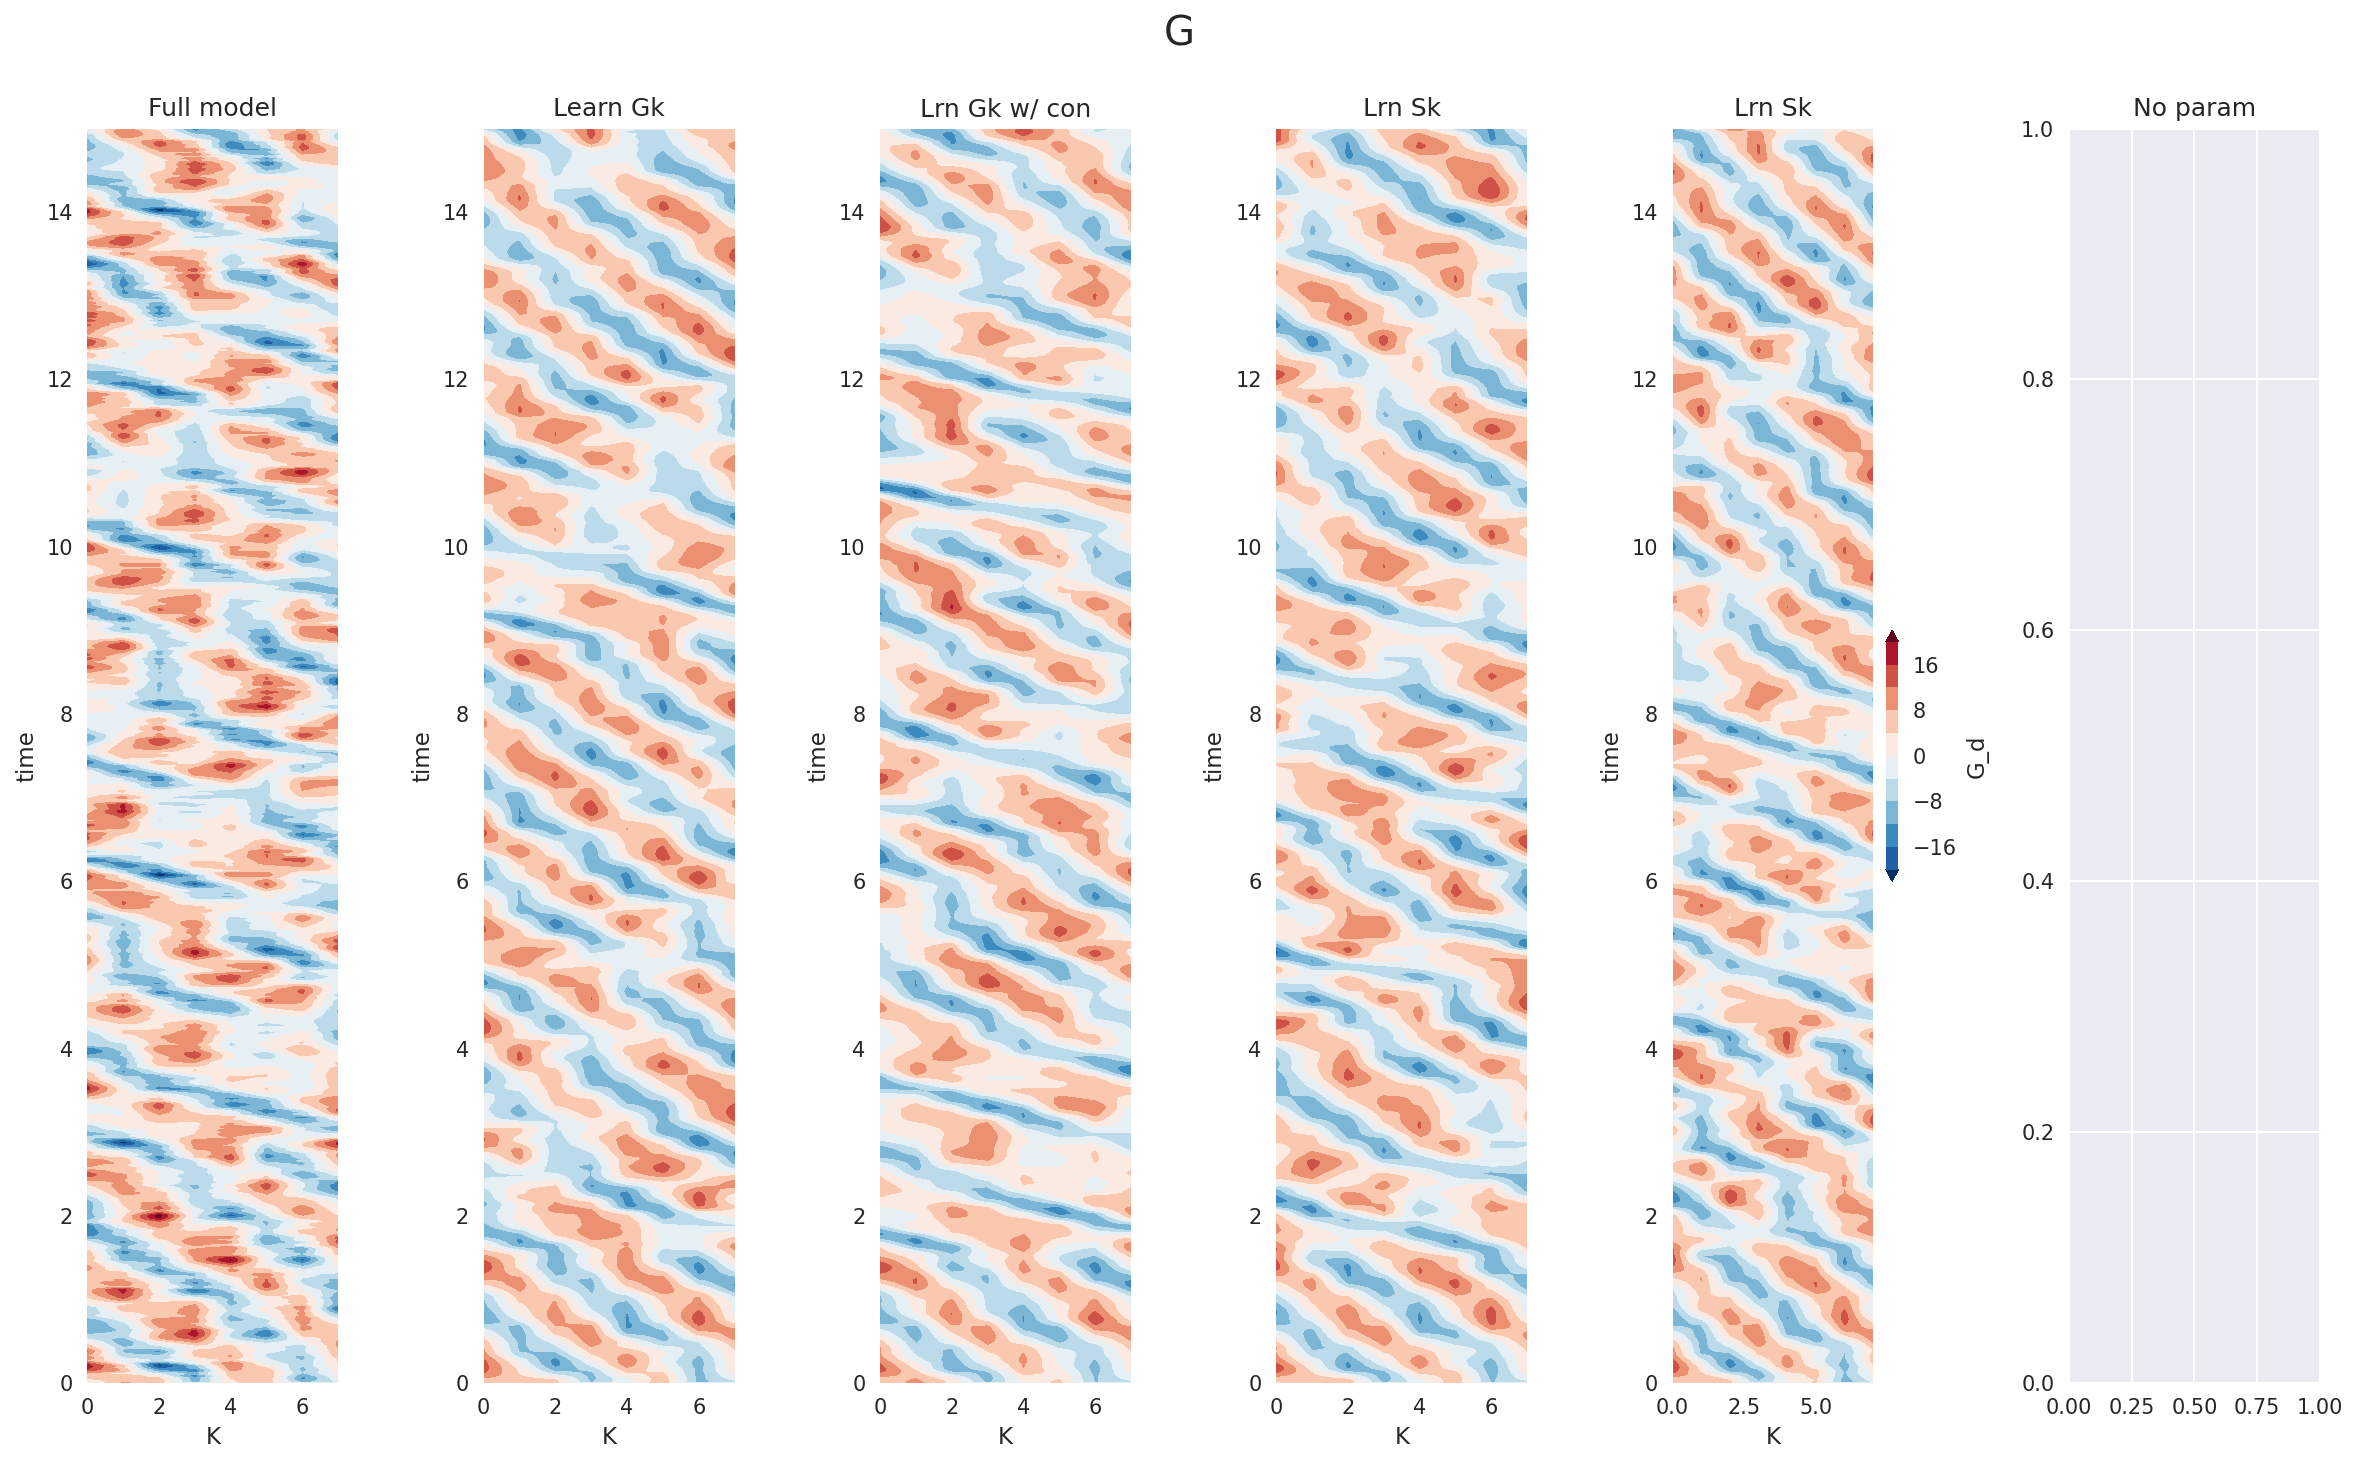

In [41]:
plt.figure(figsize=(16, 10), dpi=150)

plt.subplot(161)
G_full_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-20, 20, 11), extend="both", add_colorbar=False
)
plt.title("Full model")

plt.subplot(162)
G_a_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-20, 20, 11), extend="both", add_colorbar=False
)
plt.title("Learn Gk")

plt.subplot(163)
G_b_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-20, 20, 11), extend="both", add_colorbar=False
)
plt.title("Lrn Gk w/ con")

plt.subplot(164)
G_c_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-20, 20, 11), extend="both", add_colorbar=False
)
plt.title("Lrn Sk")

plt.subplot(165)
G_d_xr.sel(time=slice(0, 15)).plot.contourf(
    levels=np.linspace(-20, 20, 11),
    extend="both",
    add_colorbar=True,
    cbar_kwargs={"aspect": 20, "shrink": 0.2},
)
plt.title("Lrn Sk")

plt.subplot(166)
# X_noparam_xr.sel(time=slice(0, 15)).plot.contourf(levels=np.linspace(-15, 15, 9), extend='both', cbar_kwargs={'aspect':5})
plt.title("No param")
plt.suptitle("G")
plt.tight_layout()

Given the simplicity of the parameterization problem in L96 model, all the different ML parameterizations performed relatively well. We expect to see much larger gains by adding constraints in more complex realistic problems, particularly the ones that are more data limited. 

## Summary 

In this notebook we learnt how to add constraints to the learning process, and studied the impacts that this has on the trained models. 

With this notebook we wrap up the section on using neural networks to parameterize missing effects in the L96 model. In the next section we will be learning a different approach to improving models - data assimilation.